# 03. rajpurohitpooja/Salary_Prediction_Portfolio

## Predictions with ML Regression Models (T2) - train_features.csv & train_salaries.csv

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
warnings.filterwarnings('ignore')
from sklearn.linear_model import LinearRegression, Lasso, Ridge, QuantileRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, get_scorer_names
df = pd.read_csv('03_train_features.csv')
df_salary = pd.read_csv('03_train_salaries.csv')

In [2]:
# Merge these two datasets with 'jobId' column; then show all the columns, counts and their data types
df = df.merge(df_salary, on='jobId')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column               Non-Null Count    Dtype 
---  ------               --------------    ----- 
 0   jobId                1000000 non-null  object
 1   companyId            1000000 non-null  object
 2   jobType              1000000 non-null  object
 3   degree               1000000 non-null  object
 4   major                1000000 non-null  object
 5   industry             1000000 non-null  object
 6   yearsExperience      1000000 non-null  int64 
 7   milesFromMetropolis  1000000 non-null  int64 
 8   salary               1000000 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 76.3+ MB


In [3]:
# First 5 rows of the dataset
df.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [4]:
# Last 5 rows of the dataset
df.tail()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
999995,JOB1362685407682,COMP56,VICE_PRESIDENT,BACHELORS,CHEMISTRY,HEALTH,19,94,88
999996,JOB1362685407683,COMP24,CTO,HIGH_SCHOOL,NONE,FINANCE,12,35,160
999997,JOB1362685407684,COMP23,JUNIOR,HIGH_SCHOOL,NONE,EDUCATION,16,81,64
999998,JOB1362685407685,COMP3,CFO,MASTERS,NONE,HEALTH,6,5,149
999999,JOB1362685407686,COMP59,JUNIOR,BACHELORS,NONE,EDUCATION,20,11,88


## Prepare Train and Test Sets

In [5]:
# Create dummy variables from these columns: jobType, degree, major, industry
dummy_jobtype = pd.get_dummies(df['jobType'], prefix='job')
dummy_degree = pd.get_dummies(df['degree'], prefix='deg')
dummy_major = pd.get_dummies(df['major'], prefix='maj')
dummy_industry = pd.get_dummies(df['industry'], prefix='ind')
df_concat = pd.concat([dummy_jobtype, dummy_degree, dummy_major, dummy_industry,
                       df['yearsExperience'], df['milesFromMetropolis'], df['salary']], axis=1)
df_concat.head(10)

,job_CEO,job_CFO,job_CTO,job_JANITOR,job_JUNIOR,job_MANAGER,job_SENIOR,job_VICE_PRESIDENT,deg_BACHELORS,deg_DOCTORAL,...,ind_AUTO,ind_EDUCATION,ind_FINANCE,ind_HEALTH,ind_OIL,ind_SERVICE,ind_WEB,yearsExperience,milesFromMetropolis,salary
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,10,83,130
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,3,73,101
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,1,0,0,0,10,38,137
3,0,0,0,0,0,1,0,0,0,1,...,1,0,0,0,0,0,0,8,17,142
4,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,8,16,163
5,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,0,0,0,2,31,113
6,0,1,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,23,24,178
7,0,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,9,70,73
8,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,54,31
9,0,0,0,0,0,0,0,1,1,0,...,1,0,0,0,0,0,0,17,68,104


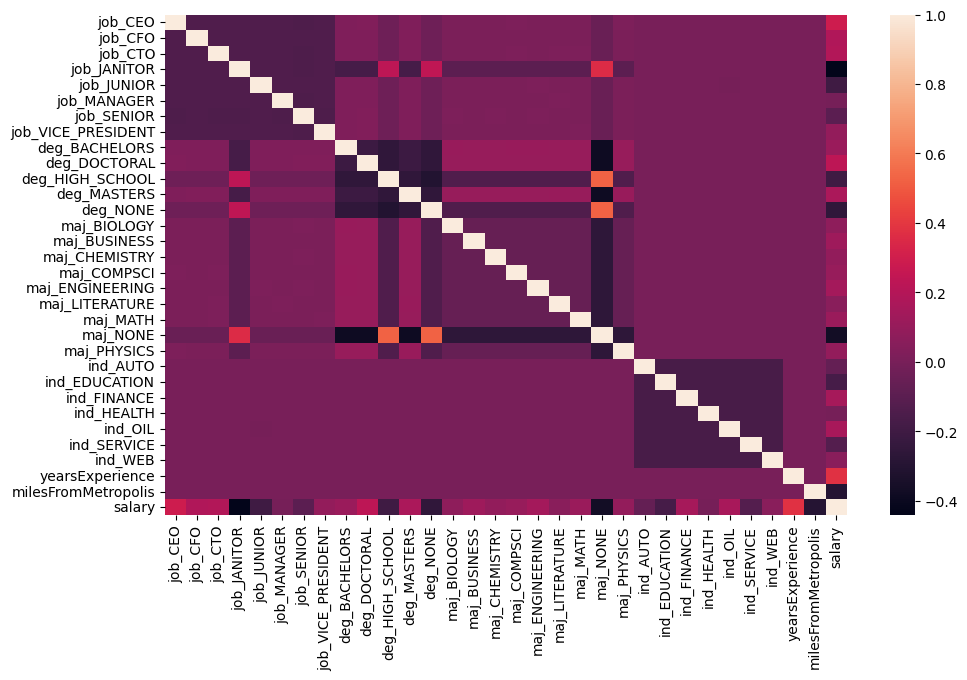

#### CORRELATION VALUES AGAINST SALARIES ####
job_CEO                0.285245
job_CFO                0.188804
job_CTO                0.189600
job_JANITOR           -0.441660
job_JUNIOR            -0.201993
job_MANAGER           -0.006781
job_SENIOR            -0.103642
job_VICE_PRESIDENT     0.090941
deg_BACHELORS          0.111923
deg_DOCTORAL           0.231391
deg_HIGH_SCHOOL       -0.203543
deg_MASTERS            0.171992
deg_NONE              -0.257349
maj_BIOLOGY            0.076341
maj_BUSINESS           0.126124
maj_CHEMISTRY          0.084046
maj_COMPSCI            0.102987
maj_ENGINEERING        0.144176
maj_LITERATURE         0.053920
maj_MATH               0.110401
maj_NONE              -0.371421
maj_PHYSICS            0.092057
ind_AUTO              -0.069913
ind_EDUCATION         -0.175148
ind_FINANCE            0.154847
ind_HEALTH            -0.003439
ind_OIL                0.156959
ind_SERVICE           -0.122361
ind_WEB                0.058949
yearsExperience        0.3

In [6]:
# Show the correlations of all concatenated columns in a heat map
plt.figure(figsize=(11,6.5))
sns.heatmap(df_concat.corr())
plt.show()
print("#### CORRELATION VALUES AGAINST SALARIES ####")
print(df_concat.corr()['salary'])

### Type 2: Use Positively Correlated Columns Only

In [7]:
# Use 80% of the dataset as train set, and 20% as test set
# X = df_concat.drop(columns='salary', axis=1)
X = df_concat[['job_CEO','job_CFO','job_CTO','job_VICE_PRESIDENT','deg_BACHELORS','deg_DOCTORAL','deg_MASTERS','maj_BIOLOGY',
               'maj_BUSINESS','maj_CHEMISTRY','maj_COMPSCI','maj_ENGINEERING','maj_LITERATURE','maj_MATH','maj_PHYSICS','ind_FINANCE',
               'ind_OIL','ind_WEB','yearsExperience']]
Y = df_concat.iloc[:,-1]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=21)
print("TRAIN SIZE:", x_train.shape, y_train.shape, "  TEST SIZE:", x_test.shape, y_test.shape)
print(X.columns)

TRAIN SIZE: (800000, 19) (800000,)   TEST SIZE: (200000, 19) (200000,)
Index(['job_CEO', 'job_CFO', 'job_CTO', 'job_VICE_PRESIDENT', 'deg_BACHELORS',
       'deg_DOCTORAL', 'deg_MASTERS', 'maj_BIOLOGY', 'maj_BUSINESS',
       'maj_CHEMISTRY', 'maj_COMPSCI', 'maj_ENGINEERING', 'maj_LITERATURE',
       'maj_MATH', 'maj_PHYSICS', 'ind_FINANCE', 'ind_OIL', 'ind_WEB',
       'yearsExperience'],
      dtype='object')


In [8]:
# Create lists to store results of error values of all regression methods
res_mse, res_rmse, res_mae, res_r2, res_cv_train, res_cv_test = [], [], [], [], [], []

# ML Regression Models

## 1 - Linear Regression

In [9]:
linreg = LinearRegression()
linreg.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': 'deprecated',
 'positive': False}

In [10]:
# Fit the training data into the linear reg. model, then make predictions on the test data
s_time = time.time()
linreg.fit(x_train, y_train)
y_pred = linreg.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.719 seconds.


In [11]:
print("COEF:", linreg.coef_)   # Estimated coefficients for the linear reg.
print("RANK:", linreg.rank_)   # Rank of matrix
print("INTERCEPT:", linreg.intercept_)   # Independent term in the linear model

COEF: [44.65952599 34.86343585 34.80404761 24.87108769 12.7039796  22.70979375
 17.73064112  5.07961794 12.53843579  6.0332088   8.98416998 15.53328457
  1.3773579  10.1527189   7.3387289  23.35123411 23.52721911 14.31255794
  2.00909314]
RANK: 19
INTERCEPT: 52.61134037737867


In [12]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   78.72955124991617 |       73
  115.54269200731044 |      100
   131.1460443382147 |      101
  120.16262365747762 |      112
  135.94191762207805 |      130
  102.75079445887141 |      108
  131.99702284728588 |      130
    70.6931786737508 |       43
   161.2239546407755 |      174
  124.18080994556033 |       88
   94.80229640224695 |      103
  149.78781516825222 |      162
  102.90897755858632 |       73
  114.34966101549696 |       96
  131.92373133399536 |      121
  133.43454295561529 |      187
  148.45780503013484 |      173
   76.13855948521677 |       89
  101.92322192299059 |      106
  129.94578966175825 |      160


In [13]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-linreg.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)         # Mean squared error
print("RMSE:", rmse)       # Root mean squared error
print("MAE:", mae)         # Mean absolute error
print("R2 SCORE:", r2)     # R2 score
print("ADJUSTED R2 SCORE:", adj_r2)   # Adjusted R2 score
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(linreg, X, Y, cv=5, return_train_score=True)    # 5-fold Cross Validation
# The time in seconds for fitting the estimator on the train set for each cv split
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
# The time in seconds for scoring the estimator on the test set for each cv split
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
# The score array for train scores for each cv split
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
# The score array for test score for each cv split
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 607.3530954159696
RMSE: 24.644534798124504
MAE: 19.82450789573937
R2 SCORE: 0.5965433786423942
ADJUSTED R2 SCORE: 0.5958743498015635

# CROSS VALIDATION #
FITTING TIME: [0.8270936  0.85643458 0.8007915  0.80084658 0.83262086] -> 0.8235574245452881
SCORING TIME: [0.01556635 0.03123236 0.03183341 0.03122616 0.03169799] -> 0.02831125259399414
TRAIN SCORE: [0.59607359 0.59551271 0.59632689 0.59552361 0.59599335] -> 0.5958860305007108
TEST SCORE: [0.59510796 0.59734645 0.59409402 0.59730853 0.59542445] -> 0.5958562814867129


## 2 - Lasso Regression

In [14]:
lasso = Lasso()
lasso.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 1000,
 'normalize': 'deprecated',
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [15]:
# Fit the training data into the lasso model, then make predictions on the test data
s_time = time.time()
lasso.fit(x_train, y_train)
y_pred = lasso.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.498 seconds.


In [16]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_)   

COEF: [30.15358689 20.3321139  20.33848204 10.39196294 10.30778587 20.2594796
 15.33015275  0.          0.          0.          0.          0.
 -0.          0.          0.         11.11704941 11.29605135  2.0911005
  1.99129078]
INTERCEPT: 70.49537350430701
ITERATIONS: 8


In [17]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   96.38215364887475 |       73
  118.71192647308159 |      100
  122.05274950314892 |      101
  125.42082008264481 |      112
  126.77053117171737 |      130
  110.66776091188181 |      108
  108.25510879971527 |      130
   88.41699052746928 |       43
   156.7516740444678 |      174
  129.40340164334754 |       88
  112.31247989168565 |      103
  148.93779477924375 |      162
  102.70259779047636 |       73
  105.11785483133906 |       96
  122.78794961101464 |      121
   136.4921944404066 |      187
  143.99216497496448 |      173
   81.79142485543565 |       89
  104.69388857082772 |      106
  117.17695201777474 |      160


In [18]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-lasso.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)          
print("RMSE:", rmse)       
print("MAE:", mae)        
print("R2 SCORE:", r2)
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 745.1283109982749
RMSE: 27.29703850234078
MAE: 21.92435475821309
R2 SCORE: 0.5050211267510423
ADJUSTED R2 SCORE: 0.5049250587689829

# CROSS VALIDATION #
FITTING TIME: [0.56271601 0.54907465 0.56609535 0.56520057 0.565202  ] -> 0.56165771484375
SCORING TIME: [0.03880906 0.01562047 0.03124666 0.03127956 0.03522134] -> 0.0304354190826416
TRAIN SCORE: [0.50512935 0.50456793 0.50554918 0.50476835 0.50547035] -> 0.5050970318952446
TEST SCORE: [0.50502308 0.506388   0.50288412 0.50568009 0.50542319] -> 0.5050796953361651


## 3 - Ridge Regression

In [19]:
ridge = Ridge()
ridge.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [20]:
# Fit the training data into the ridge model, then make predictions on the test data
s_time = time.time()
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 0.216 seconds.


In [21]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [44.65875554 34.86276308 34.80337799 24.87051711 12.70427377 22.7100142
 17.73089898  5.07921085 12.5378722   6.03278455  8.9836829  15.53265159
  1.37703193 10.15220537  7.3382754  23.35089681 23.52688072 14.31230019
  2.00909316]
INTERCEPT: 52.61189538894321
ITERATIONS: None


In [22]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   78.73010647352903 |       73
  115.54257762513654 |      100
  131.14569062541278 |      101
  120.16284172536764 |      112
   135.9415423836158 |      130
   102.7511165918867 |      108
  131.99634475558577 |      130
   70.69373383211801 |       43
  161.22355286606083 |      174
  124.18102804607314 |       88
   94.80285175635109 |      103
  149.78769447486894 |      162
  102.90912014179489 |       73
  114.34932391994766 |       96
  131.92335606291027 |      121
  133.43432781511953 |      187
  148.45753834156352 |      173
   76.13877611044308 |       89
  101.92343391781387 |      106
  129.94541094021486 |      160


In [23]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
adj_r2 = 1-(1-ridge.score(X, Y))*(len(Y)-1)/(len(Y)-X.shape[1]-1)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
print("ADJUSTED R2 SCORE:", adj_r2)
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 607.3531443343384
RMSE: 24.64453579060353
MAE: 19.824513549766504
R2 SCORE: 0.5965433461465693
ADJUSTED R2 SCORE: 0.5958743431839439

# CROSS VALIDATION #
FITTING TIME: [0.29848671 0.28205967 0.28251934 0.29850388 0.34576392] -> 0.301466703414917
SCORING TIME: [0.04072523 0.03167295 0.03129363 0.03121257 0.03127122] -> 0.03323512077331543
TRAIN SCORE: [0.59607359 0.59551271 0.59632689 0.59552361 0.59599335] -> 0.5958860303865882
TEST SCORE: [0.59510797 0.59734645 0.59409401 0.59730851 0.59542446] -> 0.5958562822682477


## 4 - Polynomial Regression

In [24]:
poly_feat = PolynomialFeatures(degree=2)
poly_feat.get_params()

{'degree': 2, 'include_bias': True, 'interaction_only': False, 'order': 'C'}

In [25]:
# Fit then transform for both training and test data (the number of columns must increase)
x_poly_train = poly_feat.fit_transform(x_train)
x_poly_test = poly_feat.fit_transform(x_test)
print(x_poly_train.shape, x_poly_test.shape)

(800000, 210) (200000, 210)


### Polynomial Regression with Lasso

In [26]:
lasso = Lasso(max_iter=500)
s_time = time.time()
lasso.fit(x_poly_train, y_train)
y_poly_pred = lasso.predict(x_poly_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 11.854 seconds.


In [27]:
print("COEF:", lasso.coef_)   # Parameter vector (w in the cost function function formula)
print("INTERCEPT:", lasso.intercept_)   # Independent term in decision function
# Number of iterations run by the coord. descent solver to reach the specified tolerance
print("ITERATIONS:", lasso.n_iter_)  

COEF: [ 0.          0.80901038  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.01479698  0.18010593  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          2.59598398  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          2.04758041  0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          2.05177082  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          1.44093603
  0.       

In [28]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)          
print("RMSE:", rmse)     
print("MAE:", mae)         
print("R2 SCORE:", r2)    
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(lasso, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 790.3356003895632
RMSE: 28.11290807422034
MAE: 22.669507581954278
R2 SCORE: 0.4749905228466481

# CROSS VALIDATION #
FITTING TIME: [0.566118   0.59663844 0.55319524 0.59584212 0.56549191] -> 0.5754571437835694
SCORING TIME: [0.01563978 0.03125215 0.04791355 0.03125191 0.01559782] -> 0.02833104133605957
TRAIN SCORE: [0.50512935 0.50456793 0.50554918 0.50476835 0.50547035] -> 0.5050970318952446
TEST SCORE: [0.50502308 0.506388   0.50288412 0.50568009 0.50542319] -> 0.5050796953361651


### Polynomial Regression with Ridge

In [29]:
ridge = Ridge(max_iter=2000)
s_time = time.time()
ridge.fit(x_poly_train, y_train)
y_poly_pred = ridge.predict(x_poly_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 1.801 seconds.


In [30]:
print("COEF:", ridge.coef_)   # Weight vector(s)
print("INTERCEPT:", ridge.intercept_)   # Independent term in decision function
print("ITERATIONS:", ridge.n_iter_)   # Actual number of iterations for each target. (Only for 'sag' & 'lsqr' solvers)

COEF: [ 0.00000000e+00  2.49323156e+01  2.02419979e+01  2.00969147e+01
  1.52048790e+01  8.73542879e+00  1.38054530e+01  1.14149104e+01
  2.79341357e+00  4.15064900e+00  3.31517894e+00  3.93967454e+00
  4.01074973e+00  1.27294054e+00  3.45450101e+00  2.68209060e+00
  1.13268524e+01  1.12428471e+01  6.27995694e+00  2.00795868e+00
  2.49323156e+01  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.00966043e+01 -1.05136238e+01 -1.02709981e+01  3.13563605e-03
  1.42631213e-01 -8.48279982e-01  2.25464751e-01  5.76443806e-01
  1.77254076e-01  5.76159803e-01  3.79523390e-02 -1.62294970e-01
  3.65804565e-01 -3.15387046e-01  1.81925495e-02  2.02419979e+01
  0.00000000e+00  0.00000000e+00 -1.02684809e+01 -1.02801262e+01
 -1.08981583e+01  1.79315432e-01 -3.75487182e-01  8.64418155e-02
  5.68948666e-03  9.32483505e-01  4.05234344e-01  2.60299373e-01
  4.08964113e-01 -3.75485316e-02  4.77503455e-02 -1.77451954e-01
 -1.38701287e-02  2.00969147e+01  0.00000000e+00 -9.94980210e+00
 -9.91688779e+00 -9

In [31]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_poly_pred), mean_squared_error(y_test, y_poly_pred, squared=False), \
    mean_absolute_error(y_test, y_poly_pred), r2_score(y_test, y_poly_pred)
print("MSE:", mse)        
print("RMSE:", rmse)       
print("MAE:", mae)          
print("R2 SCORE:", r2)      
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(ridge, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 592.40474571282
RMSE: 24.339366173193994
MAE: 19.598737812580108
R2 SCORE: 0.6064733694691868

# CROSS VALIDATION #
FITTING TIME: [0.31418657 0.31341934 0.32936311 0.29842424 0.31432199] -> 0.31394305229187014
SCORING TIME: [0.0312252  0.01564455 0.01561308 0.03127551 0.02461529] -> 0.023674726486206055
TRAIN SCORE: [0.59607359 0.59551271 0.59632689 0.59552361 0.59599335] -> 0.5958860303865882
TEST SCORE: [0.59510797 0.59734645 0.59409401 0.59730851 0.59542446] -> 0.5958562822682477


## 5 - Random Forest Regression

In [32]:
rforest = RandomForestRegressor(n_estimators=25, criterion='friedman_mse', max_depth=25, min_samples_split=2, 
                                min_samples_leaf=2, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
                                bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None, oob_score=True)
# rforest = RandomForestRegressor(n_estimators=25, criterion='friedman_mse', max_depth=20, min_samples_split=4, 
#                                 min_samples_leaf=4, min_weight_fraction_leaf=0.1, max_features=None, max_leaf_nodes=None,
#                                 bootstrap=True, warm_start=False, ccp_alpha=0.2, max_samples=None)
# rforest = RandomForestRegressor(n_estimators=40)
rforest.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.2,
 'criterion': 'friedman_mse',
 'max_depth': 25,
 'max_features': None,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.1,
 'n_estimators': 25,
 'n_jobs': None,
 'oob_score': True,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [33]:
# Fit the training data into the random forest, then make predictions on the test data
s_time = time.time()
rforest.fit(x_train, y_train)
y_pred = rforest.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 10.241 seconds.


In [34]:
print("BASE ESTIMATOR:", rforest.base_estimator_)   # Estimator used to grow the ensemble
# print("ESTIMATORS:", rforest.estimators_)   # The collection of fitted sub-estimators
print("FEATURE IMPORTANCES:", rforest.feature_importances_)   # The impurity-based feature importances
# Score of the training dataset obtained using an out-of-bag estimate. Exists only when oob_score = True
print("OOB SCORE:", rforest.oob_score_)
# Prediction computed with out-of-bag estimate on the training set. Exists only when oob_score = True
print("OOB PREDICTION:", rforest.oob_prediction_, "", len(rforest.oob_prediction_))
print("FEATURES:", rforest.n_features_in_)   # Number of features seen during fit
print("OUTPUTS:", rforest.n_outputs_, "\n")   # The number of outputs when fit is performed

BASE ESTIMATOR: DecisionTreeRegressor()
FEATURE IMPORTANCES: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
OOB SCORE: 0.138839538108828
OOB PREDICTION: [118.09230307 130.83848805  99.87553761 ... 138.28810653 124.03915128
 105.86736671]  800000
FEATURES: 19
OUTPUTS: 1 



In [35]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(rforest, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 1297.232382446697
RMSE: 36.01711235574969
MAE: 28.959846140563158
R2 SCORE: 0.13826570064787969

# CROSS VALIDATION #
FITTING TIME: [10.22857094 10.17737341 10.25732589  9.88063097 10.17693281] -> 10.144166803359985
SCORING TIME: [0.20074534 0.20424223 0.2042532  0.21958256 0.20445514] -> 0.20665569305419923
TRAIN SCORE: [0.13905547 0.13853298 0.13972303 0.13983021 0.13899634] -> 0.13922760634726997
TEST SCORE: [0.13962689 0.1404852  0.13716092 0.1379345  0.14059487] -> 0.13916047750504673


## 6 - Gradient Boosting

In [36]:
gradBoost = GradientBoostingRegressor()
gradBoost.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [37]:
# Fit the training data into the Gradient boosting regression model, then make predictions on the test data
s_time = time.time()
gradBoost.fit(x_train, y_train)
y_pred = gradBoost.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 54.024 seconds.


In [38]:
print("INIT:", gradBoost.init_)  # The estimator that provides the initial predictions
print("ESTIMATORS (FIRST 5):\n{}".format(gradBoost.estimators_[:5]))  # The collection of fitted sub-estimators
# The number of estimators as selected by early stopping (if 'n_iter_no_change' is specified).
# Otherwise, it is set to 'n_estimators'
print("# OF ESTIMATORS:", gradBoost.n_estimators_)
print("# OF FEATURES:", gradBoost.n_features_in_)  # Number of features seen during fit
print("MAX FEATURES:", gradBoost.max_features_)  # The inferred value of max_features
print("FEATURE IMPORTANCES:", gradBoost.feature_importances_)  # The impurity-based feature importances
# The i'th score 'train_score[i]' is the loss of the model at iteration i on the in-bag sample.
# If subsample == 1, this is the loss on the training data.
print("TRAIN SCORE:\n{}".format(gradBoost.train_score_))

INIT: DummyRegressor()
ESTIMATORS (FIRST 5):
[[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x21871429340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x21871429340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x21871429340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x21871429340)]
 [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
                        random_state=RandomState(MT19937) at 0x21871429340)]]
# OF ESTIMATORS: 100
# OF FEATURES: 19
MAX FEATURES: 19
FEATURE IMPORTANCES: [1.61192165e-01 1.00451280e-01 9.54780878e-02 4.98781560e-02
 3.73738948e-02 8.43953870e-02 8.45091206e-02 0.00000000e+00
 9.40023077e-03 1.19970193e-05 1.56455839e-03 1.2410275

In [39]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   83.19733996690336 |       73
  115.99895599869512 |      100
  127.57459376929368 |      101
  117.82955982753563 |      112
   133.8419516646365 |      130
  101.71478454753186 |      108
  123.68544740955429 |      130
   76.18007568817795 |       43
    159.141000534296 |      174
  119.74370907565124 |       88
   97.86232787980627 |      103
  147.17133633042482 |      162
   99.00923460271495 |       73
   110.1530692462956 |       96
  127.36511901116987 |      121
  134.20620409679398 |      187
  146.32394464838015 |      173
   78.24078716782381 |       89
   99.48351750113585 |      106
  128.93014411564064 |      160


In [40]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(gradBoost, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 609.9236714231266
RMSE: 24.696632795244103
MAE: 19.913890755962367
R2 SCORE: 0.5948357790292232

# CROSS VALIDATION #
FITTING TIME: [52.97323918 52.57265282 53.7551825  51.57800341 51.13539958] -> 52.402895498275754
SCORING TIME: [0.31505108 0.30019236 0.30952573 0.29761982 0.32976174] -> 0.31043014526367185
TRAIN SCORE: [0.59457311 0.59385112 0.59461842 0.59402061 0.5943124 ] -> 0.5942751313400647
TEST SCORE: [0.59342525 0.59538189 0.59221814 0.59559265 0.59361919] -> 0.5940474231688038


## 7 - XGBoost

In [41]:
xgb = xgboost.XGBRegressor()
xgb.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [42]:
# Fit the training data into the extreme gradient boosting regression model, then make predictions on the test data
s_time = time.time()
xgb.fit(x_train, y_train)
y_pred = xgb.predict(x_test)
print(">>> Fitting and prediction were completed in {:.3f} seconds.".format(time.time()-s_time))

>>> Fitting and prediction were completed in 4.100 seconds.


In [43]:
# Compare the predicted values against the actual ones for the top 20 rows
for i in range(20):
    print("{:20} | {:8}".format(y_pred[i], y_test.iloc[i]))

   77.42082977294922 |       73
  119.39478302001953 |      100
  134.05062866210938 |      101
  117.74444580078125 |      112
   136.7091827392578 |      130
  105.03202819824219 |      108
   121.0099105834961 |      130
    69.0289535522461 |       43
    161.537841796875 |      174
  121.74459838867188 |       88
   92.85769653320312 |      103
  145.96217346191406 |      162
   99.56478118896484 |       73
  111.12750244140625 |       96
  132.54331970214844 |      121
   138.9333038330078 |      187
  147.39971923828125 |      173
   72.78199005126953 |       89
    99.4849624633789 |      106
  125.11688232421875 |      160


In [44]:
# Results of metrics
mse, rmse, mae, r2 = mean_squared_error(y_test, y_pred), mean_squared_error(y_test, y_pred, squared=False), \
    mean_absolute_error(y_test, y_pred), r2_score(y_test, y_pred)
print("MSE:", mse)        
print("RMSE:", rmse)      
print("MAE:", mae)        
print("R2 SCORE:", r2)  
res_mse.append(mse)
res_rmse.append(rmse)
res_mae.append(mae)
res_r2.append(r2)
print("\n# CROSS VALIDATION #")
cross_val = cross_validate(xgb, X, Y, cv=5, return_train_score=True)
print("FITTING TIME:", cross_val['fit_time'], "->", cross_val['fit_time'].mean())
print("SCORING TIME:", cross_val['score_time'], "->", cross_val['score_time'].mean())
print("TRAIN SCORE:", cross_val['train_score'], "->", cross_val['train_score'].mean())
res_cv_train.append(cross_val['train_score'].mean())
print("TEST SCORE:", cross_val['test_score'], "->", cross_val['test_score'].mean())
res_cv_test.append(cross_val['test_score'].mean())

MSE: 594.1583336978764
RMSE: 24.375363252634337
MAE: 19.62410818943024
R2 SCORE: 0.6053084841840966

# CROSS VALIDATION #
FITTING TIME: [3.95597315 3.8467195  3.75290155 3.98968172 3.94802427] -> 3.8986600399017335
SCORING TIME: [0.10996222 0.10977554 0.10977364 0.10978818 0.12580609] -> 0.1130211353302002
TRAIN SCORE: [0.60754128 0.60700235 0.60767121 0.60696877 0.60746037] -> 0.6073287965812183
TEST SCORE: [0.60390267 0.60536601 0.6027369  0.60487954 0.60365066] -> 0.6041071579780537


## Results of Metrics of All ML Models Together

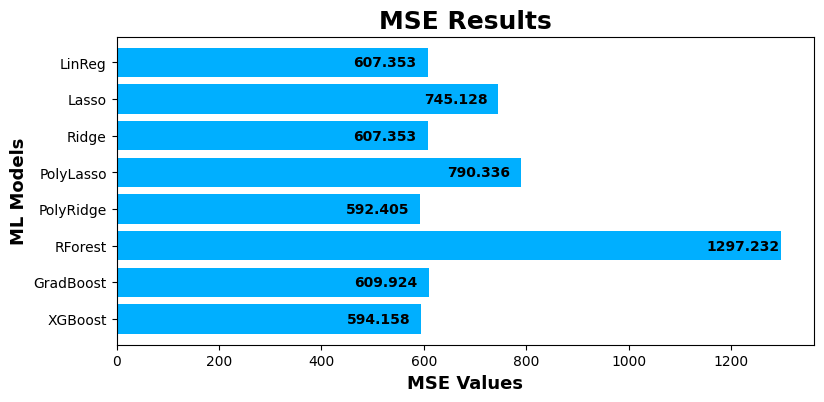

In [45]:
methods = ['LinReg', 'Lasso', 'Ridge', 'PolyLasso', 'PolyRidge', 'RForest', 'GradBoost', 'XGBoost']
plt.figure(figsize=(9,4))
plt.barh(range(8), res_mse, color='#00afff')
plt.title("MSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('MSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_mse[i]-145, i+0.12, "{:.3f}".format(res_mse[i]), fontweight='bold')
plt.show()

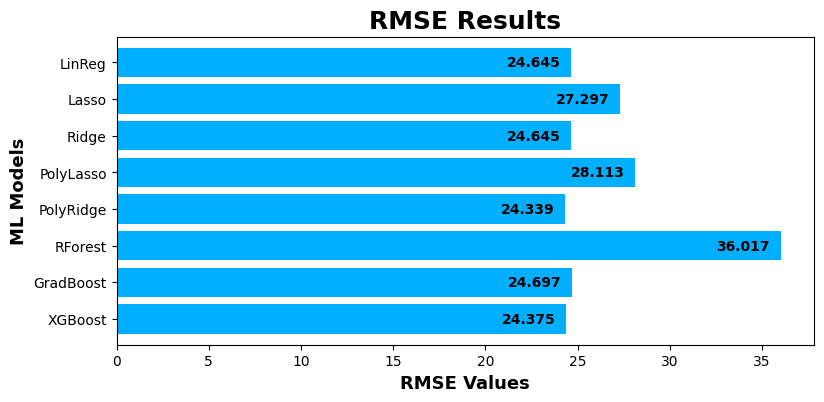

In [46]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_rmse, color='#00afff')
plt.title("RMSE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('RMSE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_rmse[i]-3.5, i+0.12, "{:.3f}".format(res_rmse[i]), fontweight='bold')
plt.show()

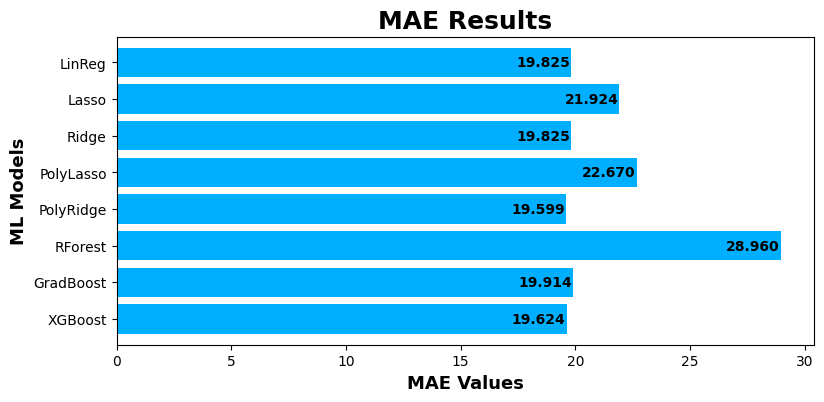

In [47]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_mae, color='#00afff')
plt.title("MAE Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('MAE Values', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_mae[i]-2.4, i+0.12, "{:.3f}".format(res_mae[i]), fontweight='bold')
plt.show()

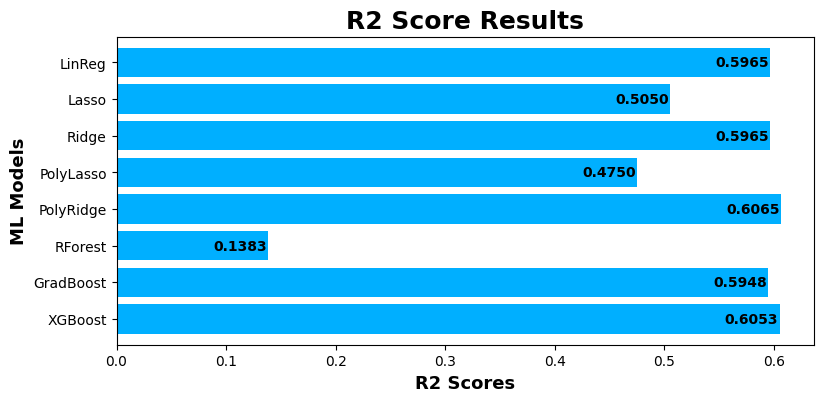

In [48]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_r2, color='#00afff')
plt.title("R2 Score Results", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('R2 Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_r2[i]-0.05, i+0.12, "{:.4f}".format(res_r2[i]), fontweight='bold')
plt.show()

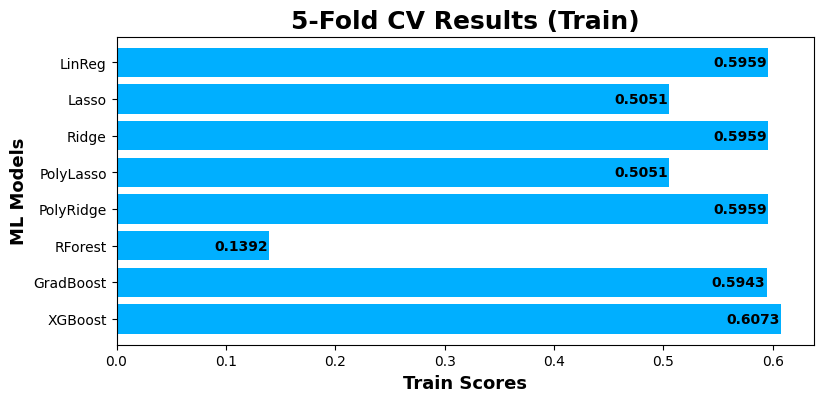

In [49]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_cv_train, color='#00afff')
plt.title("5-Fold CV Results (Train)", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('Train Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_cv_train[i]-0.05, i+0.12, "{:.4f}".format(res_cv_train[i]), fontweight='bold')
plt.show()

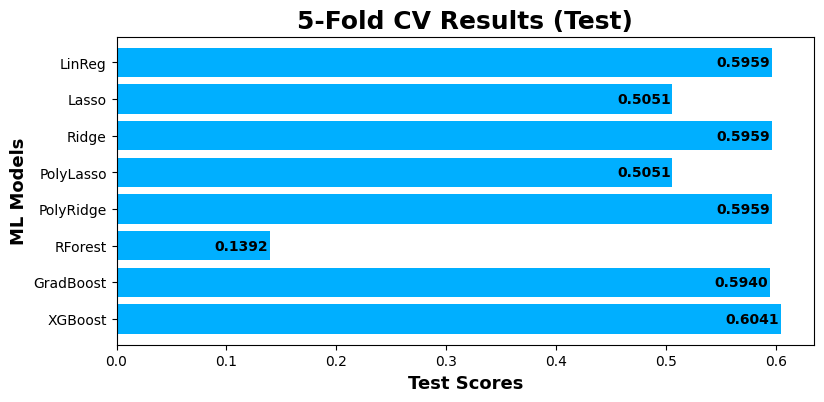

In [50]:
plt.figure(figsize=(9,4))
plt.barh(range(8), res_cv_test, color='#00afff')
plt.title("5-Fold CV Results (Test)", fontsize=18, fontweight='bold')
plt.yticks(range(8), methods)
plt.ylim(7.7,-0.7)
plt.xlabel('Test Scores', fontsize=13, fontweight='bold')
plt.ylabel('ML Models', fontsize=13, fontweight='bold')
for i in range(8):
    plt.text(res_cv_test[i]-0.05, i+0.12, "{:.4f}".format(res_cv_test[i]), fontweight='bold')
plt.show()